In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
# Метрики для измерения качества алгоритмов 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [45]:
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

# 1. Снова подгружаем данные

В очередной раз подгрузим немного данных. 

In [4]:
df = pd.read_csv('vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


In [5]:
df.columns

Index(['city', 'country', 'first_name', 'home_town', 'in_hse_memes_group',
       'is_bmm', 'is_closed', 'last_name', 'likes_memes', 'uid', 'male_dummy',
       'facebook_dummy', 'instagram_dummy', 'skype_dummy', 'twitter_dummy',
       'home_phone_dummy', 'mobile_phone_dummy', 'site_dummy',
       'can_post_dummy', 'can_see_all_posts_dummy', 'can_see_audio_dummy',
       'can_write_private_message_dummy', 'has_mobile_dummy', 'has_ava_dummy',
       'wall_comments_dummy', 'english_dummy', 'folowers_cnt', 'albums_cnt',
       'audio_cnt', 'followers_cnt', 'friends_cnt', 'gifts_cnt', 'groups_cnt',
       'photos_cnt', 'subscriptions_cnt', 'user_photos_cnt', 'videos_cnt',
       'pages_cnt', 'lang_cnt', 'change_city_school_cnt', 'schools_cnt',
       'relation_cat', 'alco_love_cat', 'smoke_love_cat', 'life_main_cat',
       'people_main_cat', 'political_cat', 'private_prof_dummy',
       'wall_can_comment_dummy', 'wall_comment_cnt', 'wall_comment_max',
       'wall_comment_mean', 'wall_co

Ровно также, как мы это делали на семинаре, предобработаем данные. Если вы не понимаете какую-то из строчек в следущем большом кодище, выясните как она работает. Напишите в чат тех-поддержки, семинаристу, сходите к гадалке. Сделайте хоть что-то, потому что скоро такой код вам придётся писать самостоятельно. 

In [117]:
# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные в том числе наш указатель пола
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,first_name,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Александра,True,True,False,Абашкова,60.0,182152789,0,0,1,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.940202,0.428571
1,Анастасия,True,True,False,Чуфистова,0.0,148020433,0,0,0,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,0.917610,0.281250
2,Александр,False,True,False,Головачев,0.0,138413935,1,0,1,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.917610,0.406250
3,Анна,False,True,False,Лобанова,0.0,366261055,0,0,0,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.945681,0.333333
4,Алексей,True,True,False,Пузырный,21.0,111252392,1,0,0,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.938266,0.341463


In [121]:
#проверим, что useful variables не содержат целевую переменную, и если содержат, удалим
if 'male_dummy' in useful_variables:
    print('yes')

In [119]:
useful_variables.remove('male_dummy')

# 2. Подготовка к моделированию.

Начнём с простого. 

__[1]__ Разделите выборку на тренировочную и тестовую. Запишите обучающую выборку в табличку `df_train`, а тестовую в `df_test`.

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=100, stratify=df['male_dummy'])

Для удобства запишем в `y` то, что мы хотим прогнозировать.

In [124]:
y_train = df_train['male_dummy'].get_values()
y_test = df_test['male_dummy'].get_values()

Посмотрим как соотносятся доли парней и девушек в тренировочной и тестовой выборках.

In [125]:
np.mean(y_train), np.mean(y_test)

(0.4588235294117647, 0.4588235294117647)

В `X` запишем то, по чему мы будем прогнозировать. 

In [126]:
# Забираем в выборку лучших из лучших 
X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

# 3. Метод ближайшего соседа

Начнём моделирование с метода ближайшего соседа. 

__[1]__ Проскалируйте переменные. Поясните в виде текста зачем нужно это делать. Надо ли скалировать переменные для деревьев? 

In [127]:
from sklearn.preprocessing import MinMaxScaler  # класс для скалирования! 

scaler = MinMaxScaler( )

scaler.fit(X_train) 

X_train_norm = scaler.transform(X_train) 
X_test_norm = scaler.transform(X_test)

__комментарий__: \
Скалировать переменные нужно, чтобы данные были в одном масштабе и не давали избыточного значения за счет своих численных параметров.\
для метода ближайших соседей мы используем только численные признаки и нам важно, чтобы близость векторов не деформировалась  зависимости от разницы в масштабе признаков. 
деревья устойчивы к разнице в масштабе признаков, поскольку соотносят значения внутри признака только с влиянием на целевую переменную, друг с другом численные значения разных признаков не сравниваются. значит, для них скалировать не обязательно.

__[1]__ Обучите на тренировочной выборке алгоритм 10 ближайших соседей. Запишите прогнозы алгоритма в переменную `y_predict`.

In [128]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 9)

knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn = knn.predict(X_test_norm)

# прогнозы вероятностей
p_pred_knn = knn.predict_proba(X_test_norm) 
p_pred_knn = p_pred_knn[:, 1]  # P(y = 1 | X)

Построим для получившегося алгоритма roc-кривую на тестовой выборке. 

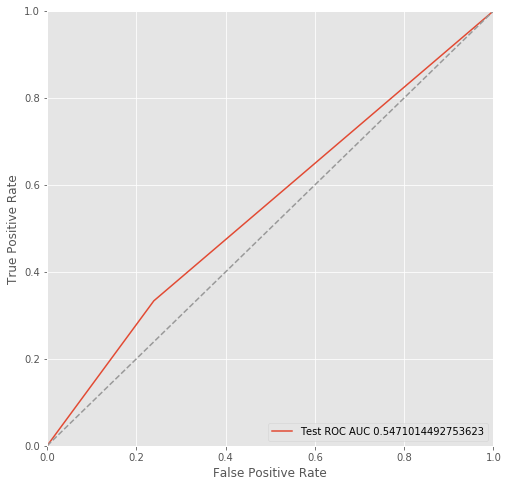

In [129]:
roc_auc_pic(y_pred_knn, y_test)

Посмотрим какой получилось accuracy (доля правильных ответов). 

In [130]:
accuracy_score(y_test, y_pred_knn)

0.5647058823529412

In [131]:
df['male_dummy'].value_counts() #выборка близка к сбалансированной

0    230
1    195
Name: male_dummy, dtype: int64

__[1]__ Какой вывод о прогнозной силе алгоритма вы можете сделать? Можно ли в данной ситуации в качестве метрики использовать `acuracy`? 

__Ответ:__ т.к. выборка близка к сбалансированной, accuracy вполне подходит как метрика качетсва.

# 4. Пытаемся улучшить работу алгоритма

Давайте попытаемся выжать из метода ближайших соседей максимум. 

__[2]__ Попробуйте перебрать разное количество соседей и разные дистанции. Насколько получилось улучшить работу классификатора? 

In [132]:
df.shape

(425, 47)

In [133]:
# Ваш код
# Решётка для перебора 
from sklearn.model_selection import GridSearchCV

# параметры, которые мы будем перебирать 
parameters = {
     'n_neighbors':range(4, 20),         # число соседей от 5 до 15
     'weights':['uniform', 'distance']   # надо ли более близких соседей учитывать с большим весом
             }

# объявили модель
knn_clf = KNeighborsClassifier()

# завернули её в решётку для поиска параметров
grid_knn = GridSearchCV(knn_clf, parameters, cv=5, scoring="roc_auc")

grid_knn.fit(X_train_norm, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': range(4, 20),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Какое сочетания параметров оказалось оптимальным? Какое качество показывает алгоритм? 

In [134]:
grid_knn.best_score_

0.6660696185986745

In [135]:
grid_knn.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

In [ ]:
#проверим работу алгоритма с наилучшими параметрами на тестовой выборке

In [136]:
knn = KNeighborsClassifier(n_neighbors = 13, weights='uniform')

knn.fit(X_train_norm, y_train)

# строим для тестовой выборки прогнозы 
y_pred_knn = knn.predict(X_test_norm)

# прогнозы вероятностей
p_pred_knn = knn.predict_proba(X_test_norm) 
p_pred_knn = p_pred_knn[:, 1]  # P(y = 1 | X)

In [137]:
accuracy_score(y_test, y_pred_knn) #видим, что качество улучшилось

0.611764705882353

# 5. Дерево 

__[2]__ Продолжаем наше путешествие в классификацию. Постройте решающее дерево. Какое качество оно показывает на тренировочной выборке? А на тестовой? Что такое переобучение? Правда ли, что дерево переобучилось? 

In [138]:
# Подшружаем дерево 
from sklearn.tree import DecisionTreeClassifier

# Объявляем дерево 
tree = DecisionTreeClassifier( )

# учим дерево 
tree.fit(X_train, y_train)

# предсказываем на тестовой выборке результаты 
y_pred_tree = tree.predict(X_test)

# предсказываем вероятности
p_pred_tree = tree.predict_proba(X_test) 
p_pred_tree = p_pred_tree[:, 1]  # P(y = 1 | X)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_pred_tree))
print('roc_auc:', roc_auc_score(y_test, p_pred_tree))

accuracy: 0.6823529411764706
roc_auc: 0.6753065774804906


In [139]:
y_pred_train = tree.predict(X_train)
y_pred_tree = tree.predict(X_test)
print('accuracy:', accuracy_score(y_train, y_pred_train))
print('accuracy:', accuracy_score(y_test, y_pred_tree))

accuracy: 1.0
accuracy: 0.6823529411764706


__Ответ:__ дерево, вероятнее всего, переобучилось, посколько показывает сто процентную точность на тренировочной выборке, и 68-ю точность на тестовой. это значит, дерево получилось слишком глубоким.

In [144]:
tree.feature_importances_

array([0.04982595, 0.02421695, 0.        , 0.09773295, 0.11891673,
       0.0091376 , 0.08058991, 0.01834796, 0.03431314, 0.00566071,
       0.06331791, 0.        , 0.02267607, 0.        , 0.        ,
       0.        , 0.        , 0.00888378, 0.        , 0.        ,
       0.        , 0.0148063 , 0.        , 0.00246772, 0.01583584,
       0.        , 0.        , 0.00888378, 0.05561421, 0.00592252,
       0.15851081, 0.        , 0.01591303, 0.        , 0.18842613])

In [148]:
X_train_c = df_train[useful_variables]
columns = X_train_c.columns

In [159]:
feats_tree = {} 
for feature, importance_tree in zip(columns, tree.feature_importances_):
    feats_tree[feature] = importance_tree #add the name/value pair 

importances_tree = pd.DataFrame.from_dict(feats_tree, orient='index').rename(columns={0: 'Gini-importance'})


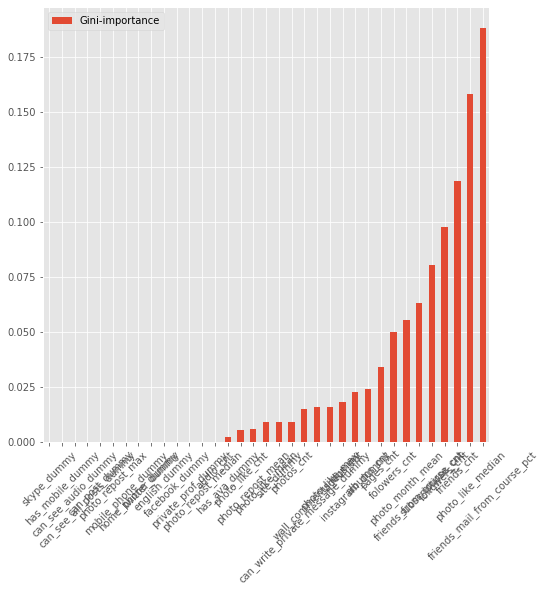

In [160]:
importances_tree.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [166]:
importances_tree.sort_values(by='Gini-importance', ascending=False)

,Gini-importance
friends_mail_from_course_pct,0.188426
photo_like_median,0.158511
friends_cnt,0.118917
followers_cnt,0.097733
subscriptions_cnt,0.080590
friends_from_course_cnt,0.063318
photo_month_mean,0.055614
folowers_cnt,0.049826
pages_cnt,0.034313
albums_cnt,0.024217


# 6. Случайный лес 

__[2]__ Попробуйте обучить случайный лес, посмотрите на качество его работы по метрике roc_auc. 

In [140]:
# Подшружаем случайный лес
from sklearn.ensemble import RandomForestClassifier

# объявляем его, будем учить 1000 деревьев
forest = RandomForestClassifier(n_estimators=500)

# учим лес 
forest.fit(X_train_norm, y_train)

# строим предсказания 
y_pred_forest = forest.predict(X_test_norm)

# предсказываем вероятности
p_pred_forest = forest.predict_proba(X_test_norm) 
p_pred_forest = p_pred_forest[:, 1]  # P(y = 1 | X)

# посчитали долю верных ответов
print('accuracy:', accuracy_score(y_test, y_pred_forest))
print('roc_auc:', roc_auc_score(y_test, y_pred_forest))

accuracy: 0.6588235294117647
roc_auc: 0.6477146042363434


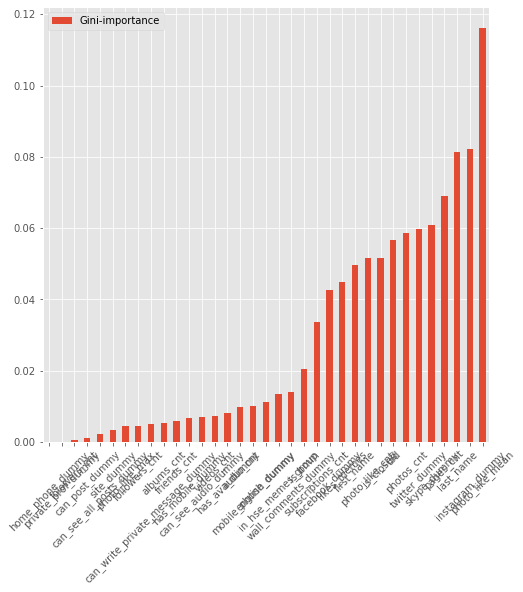

In [141]:
feats = {} 
for feature, importance in zip(columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [142]:
importances.sort_values(by=['Gini-importance'], ascending=False)

,Gini-importance
photo_like_mean,0.116206
instagram_dummy,0.082342
last_name,0.081285
pages_cnt,0.069135
skype_dummy,0.060864
twitter_dummy,0.059867
photos_cnt,0.058670
uid,0.056562
is_closed,0.051738
photo_like_cnt,0.051515


* Зачем деревья объединяют в лес? 

__Ответ:__ чтобы они имели меньшую длину, то есть не переобучались, но благодаря многочисленности действовала схема "голосования толпой".

* Какой из трёх обученных выше алгоритмов показал наилучшее качество? 

__Ответ:__ решающие деревья показали себя наилучшим образом на тестово выборке. думаю, это связано большим количеством dummy-переменных.

* Как считате, удалось ли нам научиться предсказывать пол пользователя вк? С чем это на ваш взгляд связано? 

__Ответ:__ удалось, в практически 70% случаев. 
наилучший фактор для случайного леса- это среднее количество лайков фотографий, обогнало даже фамилию (на третьем месте) и такой важный в наше время фактор, как наличие инстаграма
а для решающих деревьев, которые показали качество лучше, наиболее значимые факторы - friends_mail_from_course_pct, та же медиана лайков у фото и количество друзей. 